# Predict

In [4]:
import pandas as pd
from katlas.train import *
from katlas.dnn import *
from fastai.vision.all import *
from katlas.pssm import *

In [7]:
cddm_unk = pd.read_parquet('raw/kd_similar_cddm.parquet')

In [8]:
cddm_unk = cddm_unk[cddm_unk.within_threshold].copy()

In [10]:
# from katlas.data import *

# kd = Data.get_kd_uniprot()

In [12]:
t5 = pd.read_parquet('raw/t5_kd.parquet')

In [13]:
test_cddm = t5.loc[cddm_unk.index].reset_index()

## Predict

In [14]:
sample=pd.read_parquet('train/cddm_t5.parquet')

In [15]:
target_col = sample.columns[~sample.columns.str.startswith('T5')]

In [16]:
target_col

Index(['-20P', '-19P', '-18P', '-17P', '-16P', '-15P', '-14P', '-13P', '-12P',
       '-11P',
       ...
       '11pY', '12pY', '13pY', '14pY', '15pY', '16pY', '17pY', '18pY', '19pY',
       '20pY'],
      dtype='object', length=943)

In [17]:
feat_col = test_cddm.columns[1:]

In [18]:
feat_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

In [19]:
n_feature = len(feat_col)
n_target = len(target_col)

In [20]:
n_feature,n_target

(1024, 943)

In [21]:
def get_cnn(): return PSSM_model(n_feature,n_target,model='CNN')

In [22]:
from tqdm import tqdm

In [23]:
def get_ensemble_pred(test_df, model_name,nfold=5):
    ensemble = None
    for i in tqdm(range(nfold)):
        test_pred = predict_dl(test_df, 
                   feat_col, 
                   target_col,
                   model_func=get_cnn, # model architecture
                   model_pth=f'{model_name}_fold{i}', # only name, not with .pth
                  )
        if ensemble is None:
            ensemble = test_pred.copy()   # start with first prediction
        else:
            ensemble += test_pred         # accumulate
    
    ensemble /= 5
    return ensemble

In [24]:
pred = get_ensemble_pred(test_cddm,'cnn_cddm')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


In [25]:
pred.index=cddm_unk.index

In [27]:
pred.to_parquet('raw/pred_new_cddm.parquet')

In [28]:
pred

,-20P,-19P,-18P,-17P,-16P,-15P,-14P,-13P,-12P,-11P,...,11pY,12pY,13pY,14pY,15pY,16pY,17pY,18pY,19pY,20pY
A0A8I3S724_AURKA_CANLF_KD1,0.058566,0.047093,0.038226,0.060463,0.059130,0.054548,0.054172,0.049232,0.047558,0.059301,...,0.011735,0.011759,0.015638,0.011591,0.011264,0.015564,0.016801,0.013457,0.016039,0.015655
A0A8I5ZNK2_OXSR1_RAT_KD1,0.062874,0.044732,0.037693,0.069321,0.069203,0.048762,0.055191,0.046259,0.054198,0.052150,...,0.009368,0.014231,0.010534,0.009535,0.007872,0.018224,0.026171,0.012271,0.011304,0.023689
A0JM20_TYRO3_XENTR_KD1,0.043008,0.046507,0.053662,0.055524,0.040229,0.046882,0.063473,0.061160,0.048801,0.045304,...,0.013642,0.019686,0.012491,0.010734,0.012548,0.011841,0.014706,0.006341,0.018013,0.015684
A0JNB0_FYN_BOVIN_KD1,0.045568,0.047251,0.050904,0.050163,0.047431,0.048869,0.060826,0.054838,0.052466,0.041447,...,0.015842,0.020160,0.014444,0.012258,0.011229,0.013144,0.014181,0.007040,0.017035,0.017139
A0M8R7_MET_PAPAN_KD1,0.042183,0.045986,0.049634,0.047944,0.040924,0.046336,0.061326,0.060749,0.046776,0.042471,...,0.014246,0.020650,0.013831,0.011233,0.012048,0.012316,0.014068,0.006437,0.017606,0.016929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2B9_KS6A4_MOUSE_KD1,0.062978,0.046201,0.043306,0.047586,0.060256,0.057318,0.069925,0.054924,0.057089,0.056542,...,0.009725,0.009109,0.013359,0.011704,0.007290,0.015323,0.023502,0.008287,0.016022,0.014946
Q9Z2G7_GRK7_ICTTR_KD1,0.069125,0.050716,0.028324,0.078284,0.088472,0.043415,0.070791,0.038503,0.033959,0.072650,...,0.007297,0.005966,0.006196,0.012518,0.006082,0.022531,0.026919,0.019598,0.009070,0.015517
Q9Z2R9_E2AK1_MOUSE_KD1,0.052221,0.055948,0.027863,0.051704,0.028007,0.048318,0.038666,0.040143,0.050289,0.033800,...,0.007105,0.004360,0.002075,0.015135,0.002591,0.014851,0.005058,0.013597,0.005913,0.015426
Q9Z2W1_STK25_MOUSE_KD1,0.053220,0.045374,0.031947,0.051374,0.052299,0.055456,0.054058,0.051449,0.048602,0.050390,...,0.010350,0.012648,0.010529,0.008406,0.008619,0.020545,0.017907,0.013738,0.011008,0.021155


## test

In [29]:
cdks = cddm_unk[cddm_unk.closest_pos_index.str.contains('CDK')]

B2MVY4_CDK4_SHEEP_KD1


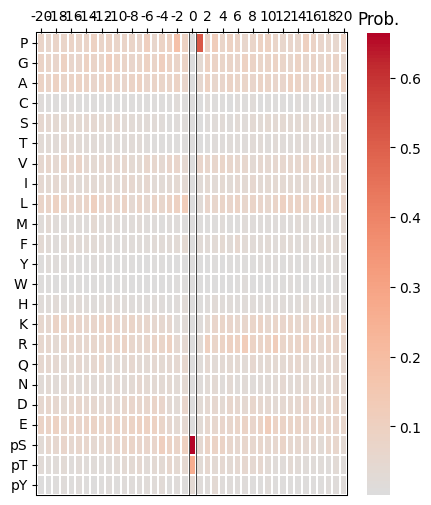

O35831_CDK17_RAT_KD1


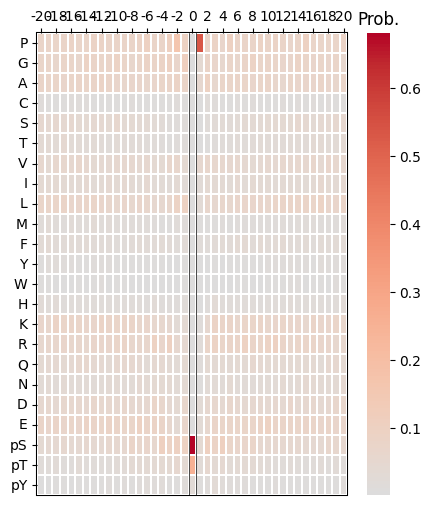

O55076_CDK2_CRIGR_KD1


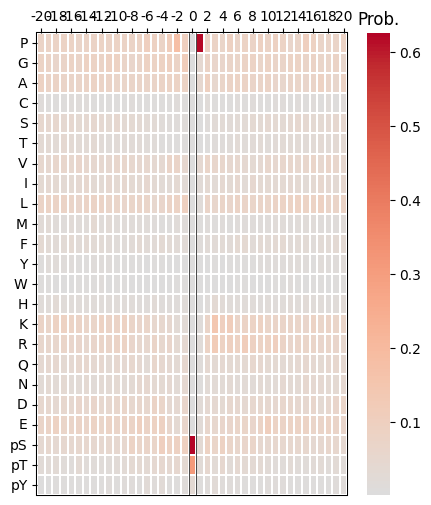

P11440_CDK1_MOUSE_KD1


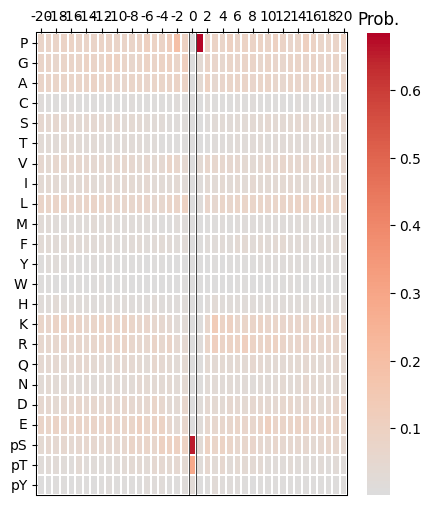

P13863_CDK1_CHICK_KD1


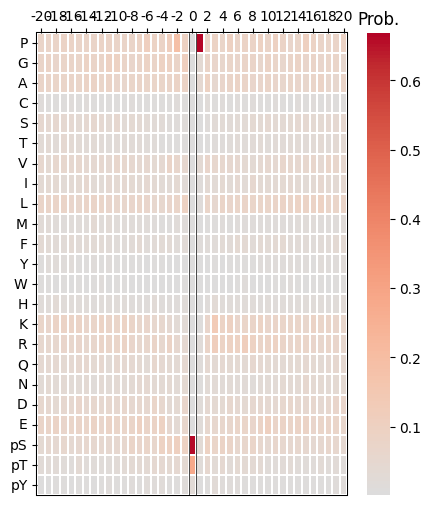

In [30]:
for i in cdks.head(5).index:
    print(i)
    plot_heatmap(recover_pssm(pred.loc[i]))
    plt.show()
    plt.close()